This is version 2 of the notebook using the dataset with actual response variables.

# TODO

- rerun manova and put it into function
- ADD THOSE DATA POINTS
- dendrogram: which groups are closest
- ask Cory whether inverse PCA transformation can be used to get transformation for future data points to be comparable (the 'index' idea)
- INVESTIGATE this >1 correlation...
- How does gait/GI change with age?

# NOTES
- When comparing L to R, correlation is a bad metric because it depends on the ordering (?).
- my response really is 'Group', not 'NVC' (this is changes from version 0 and first drafts of version 2) - OR IS IT?

# DATA INFO
-In mouse number the first digit is the cage number

In [81]:
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
from vacou import *
from plots import *
from sklearn.metrics.pairwise import pairwise_distances

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)
sns.set(style="white")
#sns.set(font="monospace")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
data_fp = '/P/vacou/data/SS31_gait_data_for_PCA.tsv'
sep_runs_data_fp = '/P/vacou/data/all_separate_runs.csv'
#d_orig = pd.read_csv(data_fp, sep='\t')
response_column = 'Group'

In [181]:
d, md, full_df = preprocess_vc(data_fp, version = 2, use_vars_fp='data/use_variables.csv')

In [179]:
sd, smd, sfull_df = preprocess_vc(sep_runs_data_fp, version = 3, use_vars_fp='data/use_variables.csv')

In [146]:
print(d.shape, md.shape, full_df.shape)
print(sd.shape, smd.shape, sfull_df.shape)

(45, 112) (45, 2) (45, 192)
(111, 112) (111, 4) (111, 494)


In [6]:
#d.to_csv('data/data_ss31.tsv', sep='\t')
#md.to_csv('data/md.tsv', sep='\t')
#full_df.to_csv('data/data_ss31_with_md.tsv', sep="\t")

# Exploratory

In [7]:
print('Take a look at some data columns')
full_df.columns.tolist()[:20]

['Group',
 'Animal',
 'Run_Duration_(s)_Mean',
 'Run_Average_Speed_(cm/s)_Mean',
 'Run_Maximum_Variation_(%)_Mean',
 'RF_Stand_(s)_Mean',
 'RF_StandIndex_Mean',
 'RF_MaxContactAt_(%)_Mean',
 'RF_MaxContactArea_(cm²)_Mean',
 'RF_MaxContactMaxIntensity_Mean',
 'RF_MaxContactMeanIntensity_Mean',
 'RF_PrintLength_(cm)_Mean',
 'RF_PrintWidth_(cm)_Mean',
 'RF_PrintArea_(cm²)_Mean',
 'RF_MaxIntensityAt_(%)_Mean',
 'RF_MaxIntensity_Mean',
 'RF_MinIntensity_Mean',
 'RF_MeanIntensity_Mean',
 'RF_MeanIntensityOfThe15MostIntensePixels_Mean',
 'RF_Swing_(s)_Mean']

In [173]:
print('Summarise data')
d.describe()

Summarise data


,Run_Average_Speed_(cm/s)_Mean,RF_StandIndex_Mean,RF_MaxContactAt_(%)_Mean,RF_Swing_(s)_Mean,RF_SwingSpeed_(cm/s)_Mean,RF_StrideLength_(cm)_Mean,RF_StepCycle_(s)_Mean,RF_DutyCycle_(%)_Mean,RF_SingleStance_(s)_Mean,RF_InitialDualStance_(s)_Mean,...,LF_BodySpeedVariation_(%)_Mean,LH_Stand_(s)_Mean,LH_StandIndex_Mean,LH_MaxContactAt_(%)_Mean,LH_Swing_(s)_Mean,LH_SwingSpeed_(cm/s)_Mean,LH_StrideLength_(cm)_Mean,LH_StepCycle_(s)_Mean,LH_DutyCycle_(%)_Mean,LH_SingleStance_(s)_Mean
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,...,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,15.492489,-3.023624,39.615562,0.165033,44.014118,6.326141,0.392749,57.856142,0.153877,0.036273,...,29.695562,0.262652,-6.517368,34.350668,0.130120,49.725466,6.098902,0.387094,63.632345,0.125360
std,4.447181,0.774734,5.762326,0.026097,7.587482,0.845784,0.052821,2.534930,0.023804,0.011402,...,8.929126,0.049168,1.712988,6.160769,0.026428,8.824091,0.955912,0.053425,5.208430,0.027986
min,8.233310,-5.539478,25.672339,0.122154,32.192698,4.544817,0.293732,52.288255,0.096604,0.015602,...,16.166612,0.169034,-11.976545,22.506915,0.083153,30.267242,3.859356,0.280508,53.652073,0.084439
25%,13.795579,-3.471036,34.480518,0.145762,39.155787,5.713459,0.361386,56.109165,0.140178,0.029114,...,22.636445,0.225131,-7.490272,29.400657,0.117073,44.535744,5.485780,0.352589,59.581155,0.107855
50%,14.787200,-2.845816,40.175398,0.160970,42.595346,6.343130,0.394577,57.581419,0.152672,0.035215,...,28.995632,0.258668,-6.335093,34.587902,0.127147,50.124704,6.238482,0.388277,64.359498,0.117324
75%,16.656712,-2.522384,42.746750,0.188699,46.903520,6.857050,0.432204,59.103890,0.169052,0.043986,...,34.241979,0.303177,-5.357041,38.768692,0.137161,54.770870,6.873361,0.425085,68.063272,0.139033
max,36.367256,-1.907316,52.107865,0.216407,71.448406,8.215144,0.486805,63.626018,0.207266,0.063617,...,57.471771,0.354071,-3.522899,47.127878,0.221950,72.947443,8.112944,0.486316,73.572929,0.222574


In [182]:
print('Take a look at metadata')
md.head()

Take a look at metadata


Group Animal
Group Animal             
YC    1.1       YC    1.1
      1.2       YC    1.2
      1.3       YC    1.3
      1.4       YC    1.4
      3.2       YC    3.2

In [183]:
print('How many observations are in each group?')
pd.DataFrame(md.Group.value_counts())

How many observations are in each group?


,Group
AT,20
YC,15
AC,10


# Top important features

### highest variance selection

In [157]:
selected_v, variances = sel_var(normalize_pd(d, 0), 0.001)

In [158]:
print("Features with highest variance")
pd.DataFrame(variances.sort_values(ascending=False)[:15], columns = ['variance (after normalisation)'])

Features with highest variance


,variance (after normalisation)
LH_InitialDualStance_(s)_Mean,0.003516
RH_TerminalDualStance_(s)_Mean,0.003433
RH_TerminalDualStance_(s)_Mean,0.003433
RH_InitialDualStance_(s)_Mean,0.003318
RH_InitialDualStance_(s)_Mean,0.003318
LF_InitialDualStance_(s)_Mean,0.003230
LF_InitialDualStance_(s)_Mean,0.003230
RF_TerminalDualStance_(s)_Mean,0.002905
RF_TerminalDualStance_(s)_Mean,0.002905
LH_TerminalDualStance_(s)_Mean,0.002823


### f classification selection (anova for all variables)

In [159]:
selected_a = sel_anova(normalize_pd(d, 0), md[response_column], k=15, mode = 'classif')

In [160]:
print("Features selected by f_regression")
pd.DataFrame(selected_a.columns)

Features selected by f_regression


,0
0,RF_StrideLength_(cm)_Mean
1,RH_StrideLength_(cm)_Mean
2,RH_SingleStance_(s)_Mean
3,LF_StrideLength_(cm)_Mean
4,LH_Swing_(s)_Mean
5,LH_StrideLength_(cm)_Mean
6,LH_SingleStance_(s)_Mean
7,FP_StrideLength_(cm)_Mean
8,RF_StrideLength_(cm)_Mean
9,RH_StrideLength_(cm)_Mean


### mutual information classification selection

In [161]:
selected_m = sel_mi(normalize_pd(d, 0), md[response_column], k=15)

In [162]:
print("Features selected by mutual_info_regression")
pd.DataFrame(selected_m.columns)

Features selected by mutual_info_regression


,0
0,RF_StrideLength_(cm)_Mean
1,RH_StrideLength_(cm)_Mean
2,LF_StrideLength_(cm)_Mean
3,LF_BodySpeed_(cm/s)_Mean
4,LH_StrideLength_(cm)_Mean
5,LH_SingleStance_(s)_Mean
6,LH_BodySpeed_(cm/s)_Mean
7,FP_StrideLength_(cm)_Mean
8,FP_BodySpeed_(cm/s)_Mean
9,RF_StrideLength_(cm)_Mean


### Comparison of feature reduction methods

In [184]:
print("Number of selected features that overlap between methods (out of 15):")
print(' - var-f_reg:', str(sum([i in selected_a.columns.tolist()
                              for i in variances.sort_values(ascending=False)[:15].index.tolist()])),
                             "features.")
print(' - var-mi_reg:', str(sum([i in selected_m.columns.tolist()
                              for i in variances.sort_values(ascending=False)[:15].index.tolist()])),
                             "features.")
print(' - f_reg-mi_reg:', str(sum([i in selected_a.columns.tolist()
                              for i in selected_m.columns.tolist()])),
                             "features. \n")

Number of selected features that overlap between methods (out of 15):
 - var-f_reg: 0 features.
 - var-mi_reg: 0 features.
 - f_reg-mi_reg: 11 features. 



Accuracy for classifier param grid for response variable Group


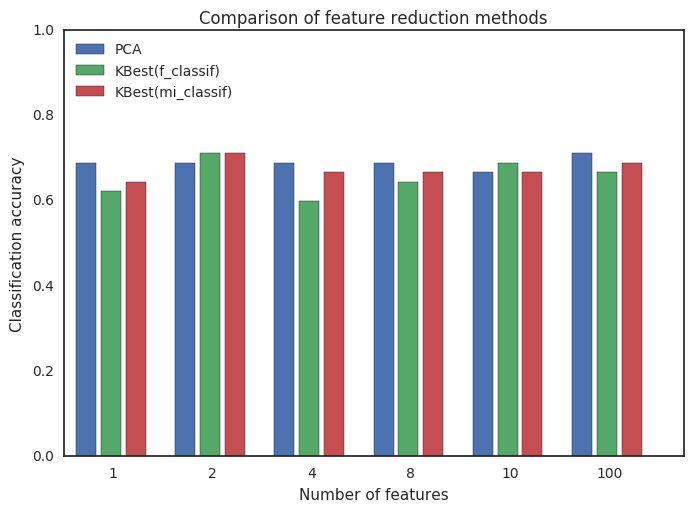

In [185]:
# regression problems:
#compare_dim_red_methods(normalize_pd(d, 0), round(md[response_column], 0), mode='regression')

# classification:
print('Accuracy for classifier param grid for response variable', response_column)
compare_dim_red_methods(normalize_pd(d, 0), md[response_column], mode='classif')

# PCA

In [186]:
comps, exvar, _ = get_pc(normalize_pd(d,0, 'normalize'))
comps.to_csv('data/PCs.tsv', sep='\t')

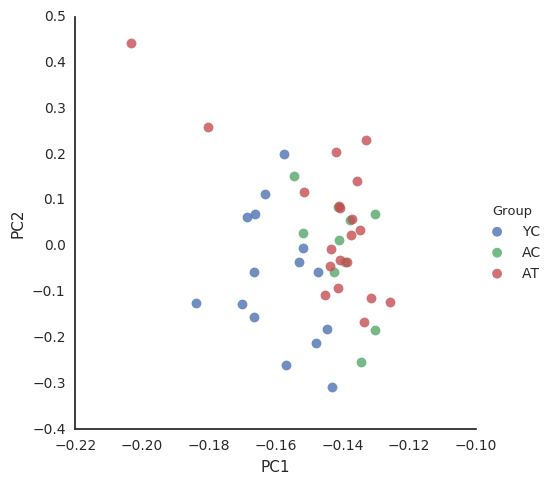

In [187]:
plot_comps = get_plot_comps(comps, md)
p2 = sns.lmplot(x='PC1', y='PC2', hue='Group', data=plot_comps, ci=None, fit_reg=False,
               scatter_kws={"s":50})

In [188]:
print('Variance explained')
pd.DataFrame(exvar).T

Variance explained


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45
0,0.876072,0.049818,0.02414,0.011496,0.008524,0.006792,0.005663,0.005047,0.002583,0.002104,...,0.000006,0.000005,0.000004,0.000003,0.000002,0.000001,5.839728e-07,2.583595e-07,1.853142e-07,1.405365e-07


The first two components seem to actually cluster both aged groups together, with some difference between the 'aged' cluster and 'young' cluster. There are some outliers from the Group 'aged treated'...

In [189]:
#p2 = sns.lmplot(x='PC1', y='PC2', hue='Trial', data=plot_comps.sort_values('Trial').iloc[:10,:],
#                ci=None, fit_reg=False, scatter_kws={"s":50})#, y_jitter=0.01, x_jitter=0.01)

In [190]:
# clusterplots for samples 1) PC3, PCall, all_var

In [192]:
palette=sns.color_palette('colorblind', len(md.Group.drop_duplicates()))
if not 'Colour' in md.columns:
    md.insert(1, 'Colour', md.Group)
    for i,g in enumerate(md.Colour.drop_duplicates()):
        md.Colour[md.Colour == g] = [palette[i] for c in range(sum(md.Colour == g))]

In [208]:
comps.index


MultiIndex(levels=[['AC', 'AT', 'YC'], ['1.1', '1.2', '1.3', '1.4', '2.1', '2.2', '2.3', '2.4', '3.1', '3.2', '3.3', '3.4', '4.1', '4.2', '4.3', '4.4', '5.1', '5.2', '5.3', '5.4']],
           labels=[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 2, 3, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]],
           names=['Group', 'Animal'])

Distances between mice based on 3 variables or PCs. Dendrograms illustrate clustering of mice.


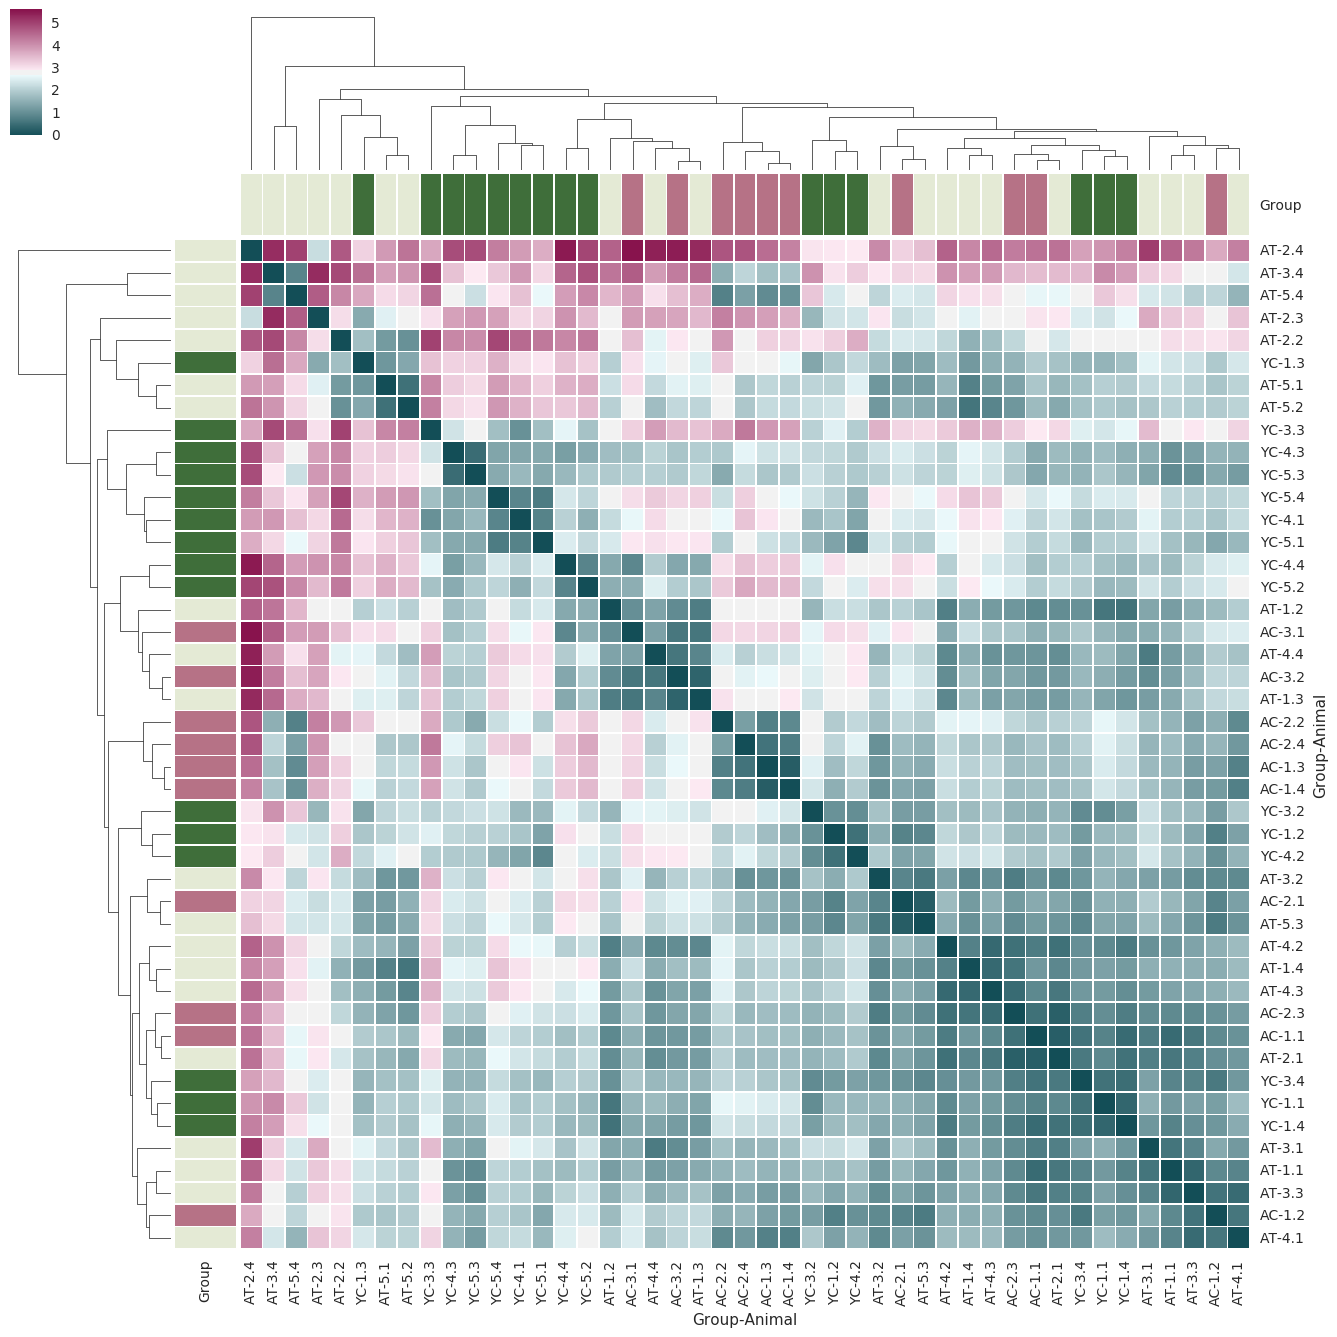

In [193]:
print('Distances between mice based on', 3, 'variables or PCs. Dendrograms illustrate clustering of mice.')
D = pd.DataFrame(pairwise_distances(comps.ix[:, :3],metric='mahalanobis'),
                columns = comps.index, index = comps.index)
#sns.clustermap(x);
p3 = distance_matrix_plots(D, "Group", figsize=(16,16));

# Differences between groups

### Is there any difference between all groups? Cluster separation - ?

### Is there any difference between all groups? Compare with one variable: Gait Index - ANOVA

In [194]:
GI = comps.ix[:, :1].rename(columns={'PC1': 'GI'})
GI.to_csv('data/GI.tsv', sep="\t")
GI['GI_scaled'] = scale(GI['GI'])
GI.describe()

,GI,GI_scaled
count,45.000000,4.500000e+01
mean,-0.148240,-1.571582e-15
std,0.015894,1.011300e+00
min,-0.203283,-3.502290e+00
25%,-0.154454,-3.953596e-01
50%,-0.143210,3.200667e-01
75%,-0.137697,6.708961e-01
max,-0.125688,1.434978e+00


In [196]:
[print(i.rstrip()) for i in anovaR('data/GI.tsv', 'GI~Group')];

            Df   Sum Sq   Mean Sq F value  Pr(>F)
Group        2 0.002776 0.0013881   6.991 0.00239 **
Residuals   42 0.008339 0.0001985
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Is there any difference between all groups? Comparison with multiple variables - MANOVA. 

Done on PCs - perhaps useful for global difference assessment, surely not for testing each variable.

http://www.sthda.com/english/wiki/manova-test-in-r-multivariate-analysis-of-variance

If the global multivariate test is significant, we conclude that the corresponding effect (treatment; here: group) is significant.

In [197]:
[print(i.rstrip()) for i in manovaR()['summary']];

          Df  Pillai approx F num Df den Df    Pr(>F)
Group      2 0.55104   5.1974      6     82 0.0001417 ***
Residuals 42
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


**RESULTS**: There seems to be a significant global difference between groups.

The next question is to determine if which of the variables does the treatment affect. In other words, we want to identify the specific dependent variables that contributed to the significant global effect. To answer this question, we can use one-way ANOVA (or univariate ANOVA) to examine separately each dependent variable.

Which variables are different between groups?

In [198]:
[print(i.rstrip()) for i in manovaR()['summary.aov']];

 Response PC1 :
            Df    Sum Sq    Mean Sq F value   Pr(>F)
Group        2 0.0027762 0.00138808  6.9915 0.002394 **
Residuals   42 0.0083386 0.00019854
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

 Response PC2 :
            Df  Sum Sq  Mean Sq F value  Pr(>F)
Group        2 0.12475 0.062377  2.9971 0.06071 .
Residuals   42 0.87411 0.020812
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

 Response PC3 :
            Df  Sum Sq  Mean Sq F value  Pr(>F)
Group        2 0.14144 0.070720  3.4716 0.04024 *
Residuals   42 0.85558 0.020371
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



### Is there a difference between any two groups? Comparison with multiple variables - MANOVA. 

In [199]:
set(comps.index.get_level_values('Group'))

{'AC', 'AT', 'YC'}

**RESULTS**: This test suggests that:
1. 'Aged Ctrl' and 'young ctrl', as well as 'ss31 aged injected' and 'young ctrl' seem to be significantly different.
2. There seems to be no significant difference between 'Aged Ctrl' and 'ss31 aged injected'.

In [202]:
[print(i.rstrip()) for i in manovaR(groups = ['AC', 'AT'])['summary']];
print('\n------\n Which variables contribute?\n')
[print(i.rstrip()) for i in manovaR(groups = ['AC', 'AT'])['summary.aov']];

          Df   Pillai approx F num Df den Df Pr(>F)
Group      1 0.091067  0.86832      3     26   0.47
Residuals 28

------
 Which variables contribute?

 Response PC1 :
            Df    Sum Sq    Mean Sq F value Pr(>F)
Group        1 0.0000925 9.2468e-05  0.3981 0.5332
Residuals   28 0.0065042 2.3229e-04

 Response PC2 :
            Df  Sum Sq  Mean Sq F value Pr(>F)
Group        1 0.02483 0.024830  1.1858 0.2855
Residuals   28 0.58627 0.020938

 Response PC3 :
            Df  Sum Sq  Mean Sq F value Pr(>F)
Group        1 0.03201 0.032010  1.2235 0.2781
Residuals   28 0.73254 0.026162



In [203]:
[print(i.rstrip()) for i in manovaR(groups = ['AC', 'YC'])['summary']];
print('\n------\n Which variables contribute?\n')
[print(i.rstrip()) for i in manovaR(groups = ['AC', 'YC'])['summary.aov']];

          Df  Pillai approx F num Df den Df    Pr(>F)
Group      1 0.57057   9.3005      3     21 0.0004123 ***
Residuals 23
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

------
 Which variables contribute?

 Response PC1 :
            Df    Sum Sq    Mean Sq F value    Pr(>F)
Group        1 0.0021353 0.00213529  20.341 0.0001578 ***
Residuals   23 0.0024144 0.00010497
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

 Response PC2 :
            Df  Sum Sq  Mean Sq F value Pr(>F)
Group        1 0.02108 0.021082  1.1333 0.2981
Residuals   23 0.42787 0.018603

 Response PC3 :
            Df  Sum Sq  Mean Sq F value   Pr(>F)
Group        1 0.13645 0.136451  10.639 0.003432 **
Residuals   23 0.29499 0.012825
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [204]:
[print(i.rstrip()) for i in manovaR(groups = ['YC', 'AT'])['summary']];
print('\n------\n Which variables contribute?\n')
[print(i.rstrip()) for i in manovaR(groups = ['YC', 'AT'])['summary.aov']];

          Df  Pillai approx F num Df den Df   Pr(>F)
Group      1 0.49645   10.188      3     31 7.95e-05 ***
Residuals 33
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

------
 Which variables contribute?

 Response PC1 :
            Df    Sum Sq    Mean Sq F value   Pr(>F)
Group        1 0.0019649 0.00196488  8.3572 0.006745 **
Residuals   33 0.0077587 0.00023511
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

 Response PC2 :
            Df  Sum Sq  Mean Sq F value  Pr(>F)
Group        1 0.12406 0.124056  5.5768 0.02426 *
Residuals   33 0.73409 0.022245
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

 Response PC3 :
            Df  Sum Sq  Mean Sq F value Pr(>F)
Group        1 0.05695 0.056950  2.7491 0.1068
Residuals   33 0.68362 0.020716



### * is neurovascular decoupling different between groups?

# Left side - right side relationships
Values in the table are correlations between each left-side gait parameter and the corresponding right-seid gait parameter. Lowest correlations are sorted first.

In [205]:
corrs = corr_L_R(full_df)
#corrs.groupby(corrs.index.get_level_values(0)).apply(lambda x: x.sort_values('correlation', ascending=True))
corrs.sort_values('correlation', ascending=True).head(10)

,group,parameter,correlation
73,AT,H_BodySpeed_(cm/s)_Mean,0.001925
12,AC,F_MinIntensity_Mean,0.002450
108,YC,F_MinIntensity_Mean,0.002692
49,AT,F_BodySpeed_(cm/s)_Mean,0.002911
132,YC,H_MinIntensity_Mean,0.004482
97,YC,F_BodySpeed_(cm/s)_Mean,0.006507
121,YC,H_BodySpeed_(cm/s)_Mean,0.007488
48,AT,F_BodySpeedVariation_(%)_Mean,0.009124
36,AC,H_MinIntensity_Mean,0.010267
1,AC,F_BodySpeed_(cm/s)_Mean,0.012837


In [206]:
corrs.sort_values('correlation', ascending=True).tail(10)

,group,parameter,correlation
56,AT,F_MaxIntensityAt_(%)_Mean,0.682724
119,YC,F_TerminalDualStance_(s)_Mean,0.694058
8,AC,F_MaxIntensityAt_(%)_Mean,0.754061
101,YC,F_MaxContactAt_(%)_Mean,0.769689
143,YC,H_TerminalDualStance_(s)_Mean,0.795289
87,AT,H_PrintWidth_(cm)_Mean,0.817555
98,YC,F_DutyCycle_(%)_Mean,0.819050
99,YC,F_InitialDualStance_(s)_Mean,0.849692
142,YC,H_Swing_(s)_Mean,0.852383
123,YC,H_InitialDualStance_(s)_Mean,1.039210


In [207]:
corrs.groupby('group').apply(lambda x: x.sort_values('correlation', ascending=True).head())\
        .drop('group',1)

parameter  correlation
group                                                
AC    12             F_MinIntensity_Mean     0.002450
      36             H_MinIntensity_Mean     0.010267
      1          F_BodySpeed_(cm/s)_Mean     0.012837
      25         H_BodySpeed_(cm/s)_Mean     0.018651
      13          F_PrintArea_(cm²)_Mean     0.020817
AT    73         H_BodySpeed_(cm/s)_Mean     0.001925
      49         F_BodySpeed_(cm/s)_Mean     0.002911
      48   F_BodySpeedVariation_(%)_Mean     0.009124
      92        H_StrideLength_(cm)_Mean     0.013699
      68        F_StrideLength_(cm)_Mean     0.015067
YC    108            F_MinIntensity_Mean     0.002692
      132            H_MinIntensity_Mean     0.004482
      97         F_BodySpeed_(cm/s)_Mean     0.006507
      121        H_BodySpeed_(cm/s)_Mean     0.007488
      120  H_BodySpeedVariation_(%)_Mean     0.025727